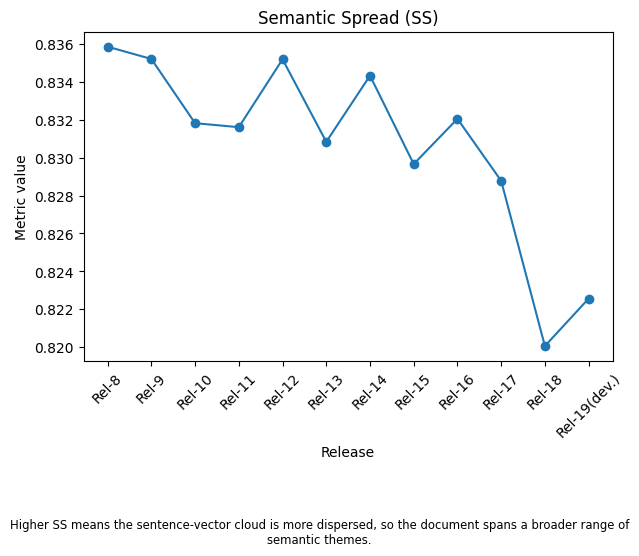

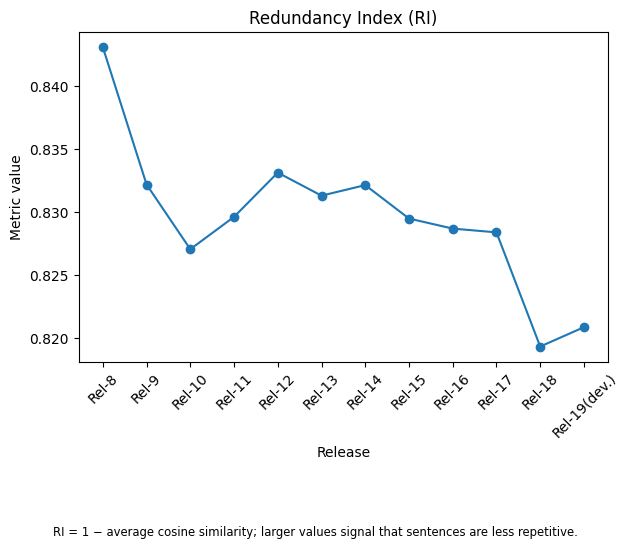

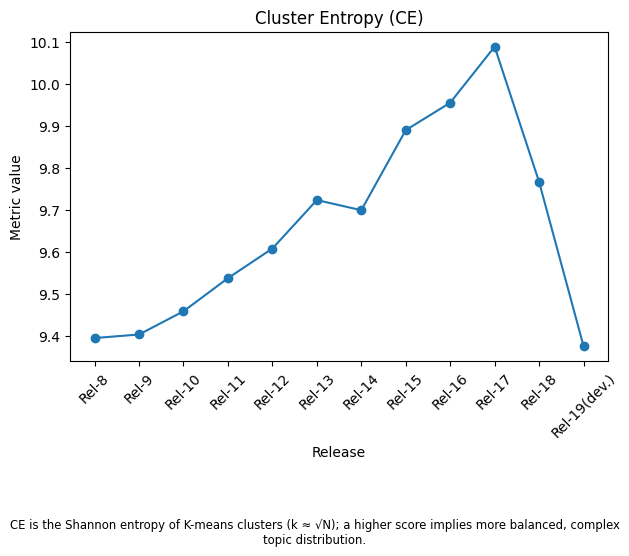

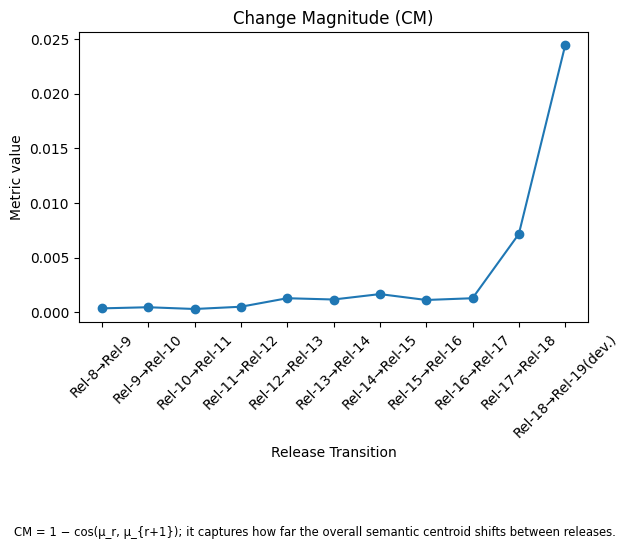

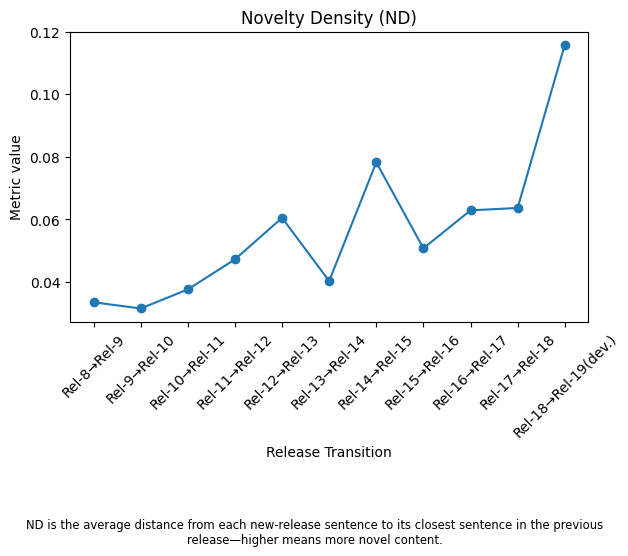

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

 
release_df = pd.read_csv('release_metrics.csv')
delta_df = pd.read_csv('delta_metrics.csv')

# ---------- Single-release metrics ----------
single_metrics = [
    ('semantic_spread',   'Semantic Spread (SS)'),
    ('redundancy_index',  'Redundancy Index (RI)'),
    ('cluster_entropy',   'Cluster Entropy (CE)')
]

single_captions = {
    'semantic_spread':
        'Higher SS means the sentence-vector cloud is more dispersed, so the document spans a broader range of semantic themes.',
    'redundancy_index':
        'RI = 1 − average cosine similarity; larger values signal that sentences are less repetitive.',
    'cluster_entropy':
        'CE is the Shannon entropy of K-means clusters (k ≈ √N); a higher score implies more balanced, complex topic distribution.'
}

for col, title in single_metrics:
    fig, ax = plt.subplots()
    ax.plot(release_df['release'], release_df[col], marker='o')
    ax.set_xlabel('Release')
    ax.set_ylabel('Metric value')
    ax.set_title(title)
    plt.xticks(rotation=45)

    # Caption centred below each plot
    fig.text(
        0.5, -0.12,
        single_captions[col],
        ha='center', va='center', fontsize='small', wrap=True
    )
    plt.tight_layout()
    plt.show()

# ---------- Cross-release (delta) metrics ----------
delta_df['transition'] = (
    delta_df.apply(lambda r: f"{r['from']}→{r['to']}", axis=1)
)

delta_metrics = [
    ('change_magnitude', 'Change Magnitude (CM)'),
    ('novelty_density',  'Novelty Density (ND)')
]

delta_captions = {
    'change_magnitude':
        'CM = 1 − cos(μ_r, μ_{r+1}); it captures how far the overall semantic centroid shifts between releases.',
    'novelty_density':
        'ND is the average distance from each new-release sentence to its closest sentence in the previous release—higher means more novel content.'
}

for col, title in delta_metrics:
    fig, ax = plt.subplots()
    ax.plot(delta_df['transition'], delta_df[col], marker='o')
    ax.set_xlabel('Release Transition')
    ax.set_ylabel('Metric value')
    ax.set_title(title)
    plt.xticks(rotation=45)

    fig.text(
        0.5, -0.12,
        delta_captions[col],
        ha='center', va='center', fontsize='small', wrap=True
    )
    plt.tight_layout()
    plt.show()


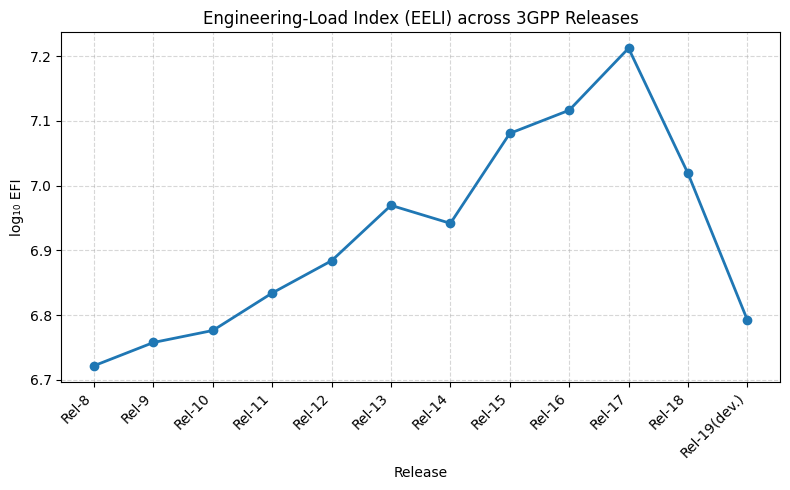

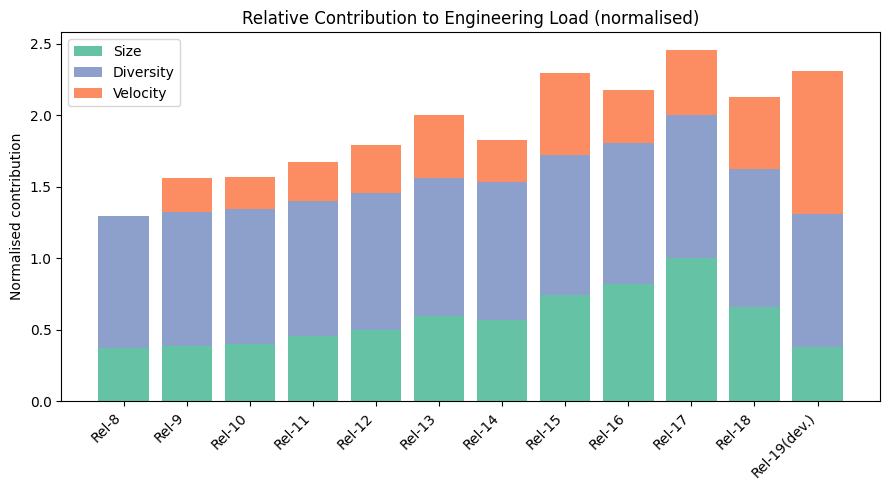

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the two CSV files that the user uploaded
release_df = pd.read_csv('release_metrics.csv')
delta_df = pd.read_csv('delta_metrics.csv')

# 1)  -------  Compute the Engineering‑Footprint/Load Index (EFI + EELI)  ----

# Diversity term  D_r  =  CE × SS / RI
release_df['D'] = release_df['cluster_entropy'] * release_df['semantic_spread'] / release_df['redundancy_index']

# Velocity term  V_r  =  CM + ND  (taken from delta metrics, aligned by “to” release)
delta_df['V'] = delta_df['change_magnitude'] + delta_df['novelty_density']
release_df = release_df.merge(delta_df[['to', 'V']], left_on='release', right_on='to', how='left')
release_df.rename(columns={'V': 'velocity'}, inplace=True)
release_df['velocity'] = release_df['velocity'].fillna(0.0)   # Rel‑8 has no previous version

# Engineering‑Footprint Index  EFI_r  =  Size × Diversity × (1+Velocity)
release_df['EFI']  = release_df['sentences'] * release_df['D'] * (1.0 + release_df['velocity'])
release_df['EELI'] = np.log10(release_df['EFI'])              # log‑scaled for readability

# -----  Plot #1 : EELI vs Release  -----
plt.figure(figsize=(8,5))
plt.plot(release_df['release'], release_df['EELI'], marker='o', linewidth=2)
plt.title('Engineering‑Load Index (EELI) across 3GPP Releases')
plt.ylabel('log\u2081\u2080 EFI')
plt.xlabel('Release')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2)  -------  Stacked bar showing the relative contribution of Size / Diversity / Velocity  -----
#   (Normalised so all bars have a comparable scale)
max_S = release_df['sentences'].max()
max_D = release_df['D'].max()
max_V = release_df['velocity'].max()

stack_df = pd.DataFrame({
    'Release'   : release_df['release'],
    'Size'      : release_df['sentences'] / max_S,
    'Diversity' : release_df['D']         / max_D,
    'Velocity'  : release_df['velocity']  / max_V,
})

plt.figure(figsize=(9,5))
bottom = np.zeros(len(stack_df))
for col, colour in zip(['Size', 'Diversity', 'Velocity'],
                       ['#66c2a5', '#8da0cb', '#fc8d62']):
    plt.bar(stack_df['Release'], stack_df[col], bottom=bottom,
            label=col, color=colour)
    bottom += stack_df[col]

plt.title('Relative Contribution to Engineering Load (normalised)')
plt.ylabel('Normalised contribution')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
